### Import libraries and define some globally useful parameters


In [1]:
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
from scipy.stats import zscore
from util_cluster import some_cluster
import glob
import pandas as pd
from collections import OrderedDict

INPUT_FOLDER = '../processed_data/'
HOT = OrderedDict()
HOT['walk']= np.array([1, 0, 0, 0, 0, 0])
HOT['train']= np.array([0, 1, 0, 0, 0, 0])
HOT['subway']= np.array([0, 0, 1, 0, 0, 0])
HOT['taxi']= np.array([0, 0, 0, 1, 0, 0])
HOT['bus']= np.array([0, 0, 0, 0, 1, 0])
HOT['bike']= np.array([0, 0, 0, 0, 0, 1])
HOT['UNK']= np.array([0, 0, 0, 0, 0, 0])


colors = ['r', 'g', 'b', 'y', 'm', 'c', 'k']
lbl_clr = zip(HOT.keys(), colors)
title = ''
for lbl, clr in lbl_clr:
    title += lbl + '=' +clr + ','
print(title[:-1])

walk=r,train=g,subway=b,taxi=y,bus=m,bike=c,UNK=k


### Functions to munge the data


In [2]:
def munge():
    def clean_label(label):
        # Pandas treats NaN's as floats. So in the next line we, effectively, check for NaN
        if not isinstance(label,float):
          return label.lstrip(',').rstrip(',').replace(',,', ',')


    headers_metadf = ['trajectory_id', 'start_time', 'end_time', 'v_ave', 'v_med', 'v_max', 'v_std', 'a_ave', 'a_med', 'a_max',
                      'a_std','labels']

    list_df_metadata = []

    for file in glob.glob(INPUT_FOLDER + "*_metadata.csv"):
        df_metadata = pd.read_csv(file, index_col=0)
        list_df_metadata.append(df_metadata)

    
    df_metadata = pd.concat(list_df_metadata).dropna(subset=['v_ave', 'v_med', 'v_max', 'v_std', 'a_ave', 'a_med', 'a_max','a_std'])
    
    X = df_metadata.as_matrix(['v_ave', 'v_med', 'v_max', 'v_std', 'a_ave', 'a_med', 'a_max','a_std'])
    y = df_metadata['labels'].values

    N = X.shape[0]
    D = 6

    # Rewrite the label strings to hot-vectors
    # Note that labels are not mutually exclusive!
    Y = np.zeros((N,D),dtype=np.int16)
    for iy in range(N):
        lbl = y[iy]
        # Pandas treats NaN's as floats. So in the next line we, effectively, check for NaN
        if not isinstance(lbl, float):
            for key, value in HOT.items():
                if key in lbl:
                    Y[iy] += value
    return X,Y

### Functions to preprocess data


In [3]:
def remove_outliers(X,y):
    """Start on visualization.
    Remove all data outside (MAX_STD) standard deviations"""
    MAX_STD = 2.0
    mean = np.mean(X, 0)
    std = np.std(X, 0)
    mask = []
    for i, x in enumerate(X):
        if np.isnan(np.sum(x)):
            continue
        elif np.any(np.abs((x - mean) / std) > MAX_STD):
            continue
        else:
            mask.append(i)
    X = X[mask]
    y = y[mask]
    X = zscore(X)
    return X,y

### The working horses: PCA and tSNE

In [4]:
def PCA(X,y):
    """PCA"""
    PCA_model = TruncatedSVD(n_components=2)
    reduced = PCA_model.fit_transform(X)
    return reduced,y

def tSNE(X,y,perp=30):
    """Subsample to prevent memory error
    - perp: the perplexity for the tSNE algo"""
    N = X.shape[0]
    ind = np.random.choice(N,10000)
    X = X[ind]
    y = y[ind]

    tSNE_model = TSNE(verbose=2,perplexity=perp,min_grad_norm=1E-07,n_iter=300,angle=0.6)
    reduced_tsne = tSNE_model.fit_transform(X)
    return reduced_tsne,y


### Our cockpit
Here we load the data and preprocess.
Next we run the algorithms and plot

----Munge the data----
----Start PCA----


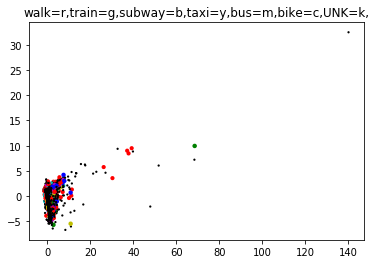

In [5]:
print('----Munge the data----')
X, y = munge()
X,y = remove_outliers(X,y)
N,D = y.shape

#PCA
print('----Start PCA----')
X_red,y_red = PCA(X,y)
plt.figure()
y_color,y_s = some_cluster(y_red, colors)
plt.scatter(X_red[:, 0], X_red[:, 1],c = y_color,s=y_s ,marker='o', linewidths=0)
plt.title(title)
plt.savefig('pca.png')
plt.show(block=True)
# If the plot doesnt show after above line, then change the MATPLOTLIB settings for your interpreter

plt.figure()
f4, ax4 = plt.subplots(1, D)
for d in range(D):
    ax4[d].scatter(X_red[:, 0], X_red[:, 1],c =y_red[:,d] ,marker='*', linewidths=0)
    ax4[d].set_title('Mode%3i'%d)
plt.setp([a.get_xticklabels() for a in ax4], visible=False)
plt.setp([a.get_yticklabels() for a in ax4], visible=False)
plt.savefig('pca_table.png')

In [6]:
#tSNE
print('----Start tSNE----')
for per in [300,400,500]:
    print('-'*10+'tSNE on perplexity %i'%per + '-'*10)
    X_red, y_red = tSNE(X, y, per)
    plt.figure()
    y_color, y_s = some_cluster(y_red, colors)
    #color
    plt.scatter(X_red[:, 0], X_red[:, 1], c=y_color, s=y_s, marker='o',
                linewidths=0)
    plt.title(title)
    plt.savefig('tSNE%i.png' % per)
    #black-white
    plt.scatter(X_red[:, 0], X_red[:, 1], c='k', s=y_s, marker='o',
                linewidths=0)
    plt.title(title)
    plt.savefig('tSNE_bw%i.png'%per)
    #
    plt.figure()
    f3, ax3 = plt.subplots(1, D)
    for d in range(D):
        ax3[d].scatter(X_red[:, 0], X_red[:, 1],c =y_red[:,d] ,marker='*', linewidths=0)
        ax3[d].set_title('Mode%3i'%d)
    plt.setp([a.get_xticklabels() for a in ax3], visible=False)
    plt.setp([a.get_yticklabels() for a in ax3], visible=False)
    plt.savefig('tsne_table.png')

----Start tSNE----
----------tSNE on perplexity 300----------
[t-SNE] Computing pairwise distances...
[t-SNE] Computing 901 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000


KeyboardInterrupt: 